In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Data

In [65]:
# Load the CSV file
teraterm_path = "C:/Users/hylth/AppData/Local/teraterm5/"
file_name = "LooseGripZTaps.csv"
data = pd.read_csv(teraterm_path + file_name)

# Assert that the data has 7 columns.
assert data.shape[1] == 7, "Data should have 7 columns."

# Assign column names.
data.columns = ['t', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Scale data to gs and degs/sec.
data['t'] = data['t'] / 1_000_000
data[['ax', 'ay', 'az']] = data[['ax', 'ay', 'az']] / 2048 # For a full-scale of 16gs.
data[['gx', 'gy', 'gz']] = data[['gx', 'gy', 'gz']] / 65.5 # For a full-scale of ??.

# Create 'Contact' Label

In [66]:
# Define a threshold for contact detection (example: acceleration > 10)
threshold = 2

# Create labels based on the threshold
data['contact'] = ((data['ax']**2 + data['ay']**2 + data['az']**2)**0.5 > threshold).astype(int)

# Keep only the first sample of each contact event
contact_diff = data['contact'].diff().fillna(0)
first_contact_idx = data.index[(contact_diff == 1) & (data['contact'] == 1)]
# Only keep the first index in each group of indices that are close together (e.g., within 10 samples)
min_separation = 100
filtered_contact_idx = []
for idx in first_contact_idx:
    if not filtered_contact_idx or idx - filtered_contact_idx[-1] > min_separation:
        filtered_contact_idx.append(idx)
filtered_contact_idx = pd.Index(filtered_contact_idx)
# Make contact only 1 for the filtered contact indicies, else 0.
data['contact'] = 0
data.loc[filtered_contact_idx, 'contact'] = 1

# Display the updated dataset
print(data.head())

print(first_contact_idx)
print(filtered_contact_idx)

          t        ax        ay        az          gx          gy          gz  \
0  1.003696  0.063965  0.049316  0.995117 -500.274809 -500.274809 -500.274809   
1  1.003949  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809   
2  1.004201  0.063477  0.061523  1.099609 -500.274809 -500.274809 -500.274809   
3  1.004454  0.065430  0.050781  1.060547 -500.274809 -500.274809 -500.274809   
4  1.004707  0.065918  0.060547  1.095215 -500.274809 -500.274809 -500.274809   

   contact  
0        0  
1        0  
2        0  
3        0  
4        0  
Index([ 1496,  1500,  1530,  3030,  3049,  3054,  3079,  4533,  4557,  4563,
        4571,  4577,  5865,  5883,  5889,  7304,  7322,  7328,  7388,  8710,
        8727,  8734,  8758, 10044, 10049, 10068, 10083, 10091, 11462, 11486,
       11509],
      dtype='int64')
Index([1496, 3030, 4533, 5865, 7304, 8710, 10044, 11462], dtype='int64')


# Plot Stuff

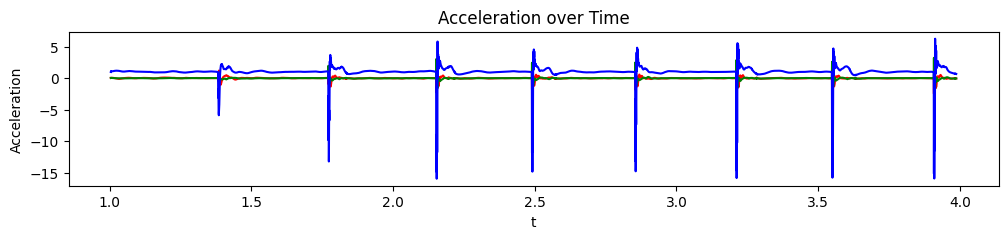

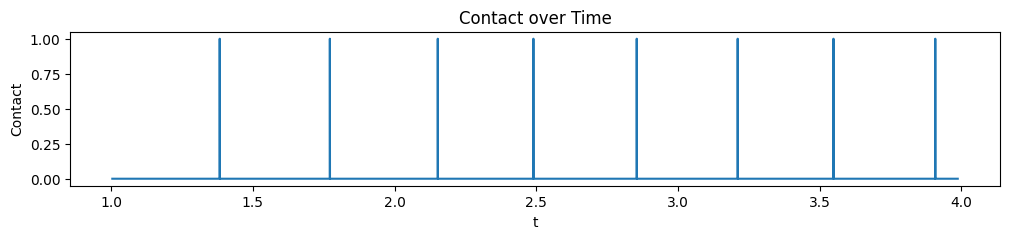

In [67]:
import matplotlib.pyplot as plt

# Plot ax, ay, az over time
plt.figure(figsize=(12, 2))
plt.plot(data['t'], data['ax'], label='ax', color='red')
plt.plot(data['t'], data['ay'], label='ay', color='green')
plt.plot(data['t'], data['az'], label='az', color='blue')
plt.xlabel('t')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.show()

# Plot contact over time
plt.figure(figsize=(12, 2))
plt.plot(data['t'], data['contact'], label='contact')
plt.xlabel('t')
plt.ylabel('Contact')
plt.title('Contact over Time')
plt.show()

# Model Class Definitions

In [68]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # Activation for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))  # Sigmoid activation for output
        return x
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state (h0) with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through RNN
        out, _ = self.rnn(x, h0)

        # Pass the last time step's output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return torch.sigmoid(out)  # Sigmoid activation for binary classification

# Create Normalized Feature-Label Tensors

In [73]:
# Create sequences from the data. Function outputs two arrays, size (num_batches, seq_length, num_features) and (num_batches, num_labels).
def create_sequences(data, labels, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # Extract sequence
        targets.append(labels[i])   # Target is the label before the sequence.
    return np.array(sequences), np.array(targets)

# Separate features and label
# X contains the sensor readings: acceleration (ax, ay, az).
# y contains the binary contact label (0: no contact, 1: contact)
X = data[['ax', 'ay', 'az']].values
y = data['contact'].values

# Split the data into training and testing arrays.
# 75% for training, 25% for testing.
X_train = X[:int(len(X) * 0.75)]
X_test = X[int(len(X) * 0.75):]
y_train = y[:int(len(y) * 0.75)]
y_test = y[int(len(y) * 0.75):]

# Normalize data. Mean = 0, StdDev = 1.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create sequences for training and testing.
sequence_length = 30
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Convert sequences and targets to PyTorch tensors for training and testing
# Unsqueeze informs the NN that there is 1 label type, 'contact'.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1).to(device) 
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1).to(device)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([8802, 30, 3])
torch.Size([8802, 1])
torch.Size([2914, 30, 3])
torch.Size([2914, 1])


# Initialize Neural Network (RESETS MODEL)

In [ ]:
# Model parameters
input_size = X_train.shape[1]  # Number of features (3: ax, ay, az)
hidden_size = 16  # Number of neurons in the hidden layers
output_size = 1  # Binary classification (contact or no contact)
num_layers = 1

# Initialize the model
model = SimpleRNN(input_size, hidden_size, output_size, num_layers)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training Loop

In [ ]:
# Training loop
epoch = 0
last_loss = float('inf')
milestone = 1
while True:
    epoch += 1

    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Early stopping: break if loss increases compared to previous epoch
    if loss.item() > last_loss:
        print(f"Early stopping at epoch {epoch+1} due to increasing loss. {loss.item()} > {last_loss}")
        break
    last_loss = loss.item()

    # Print loss every 100 epochs
    if loss.item() < milestone:
        print(f'Epoch [{epoch}], Loss: {loss.item():.8f}')
        while loss.item() < milestone:
            milestone = milestone/2

# Evaluate Model

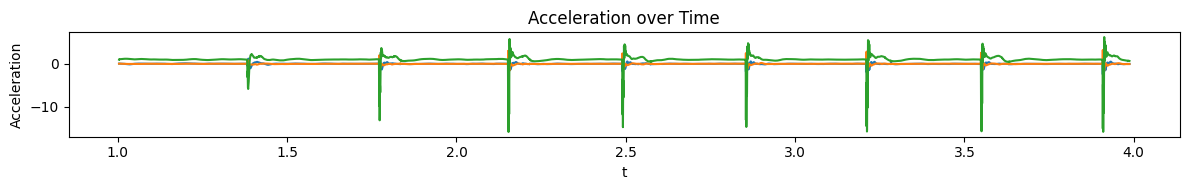

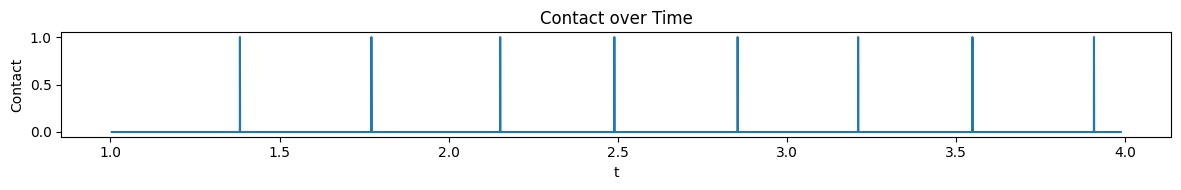

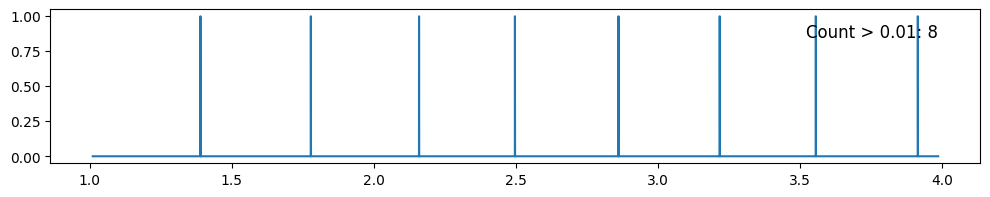

Actual contact indices: [1496, 3030, 4533, 5865, 7304, 8710, 10044, 11462]
Predicted contact indices (prob > 0.9): [1526, 3060, 4563, 5895, 7334, 8740, 10075, 11492]


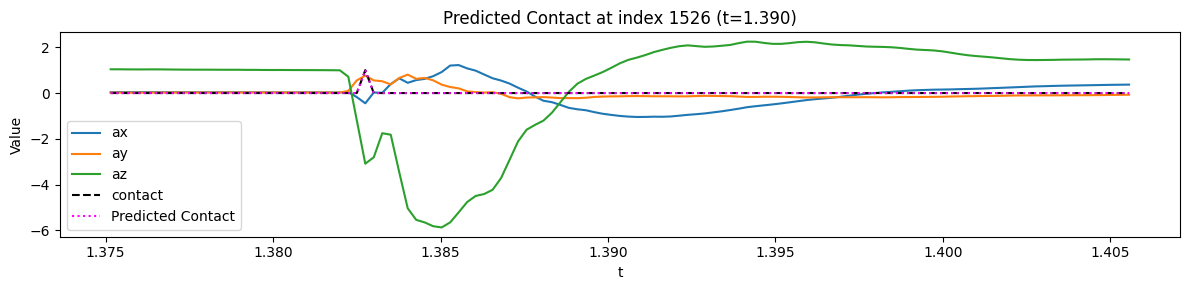

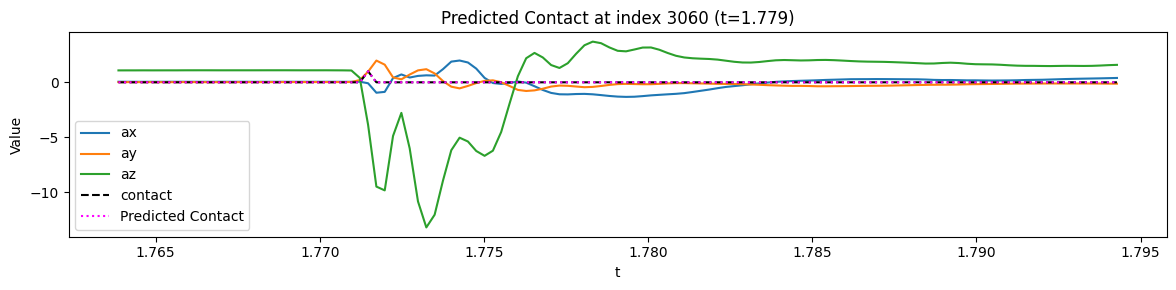

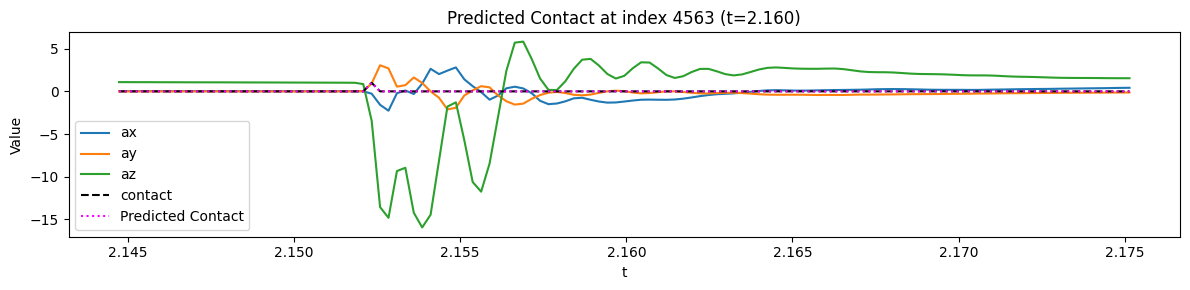

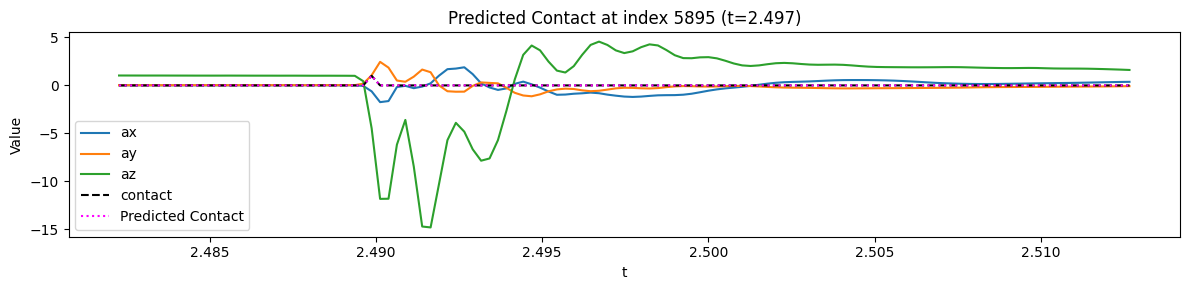

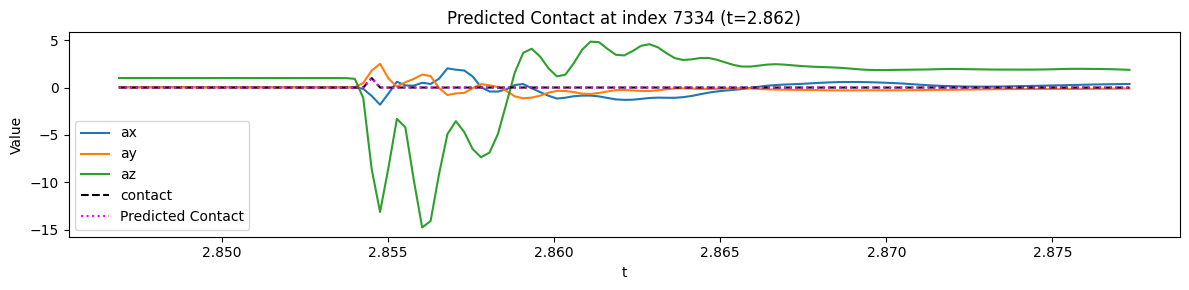

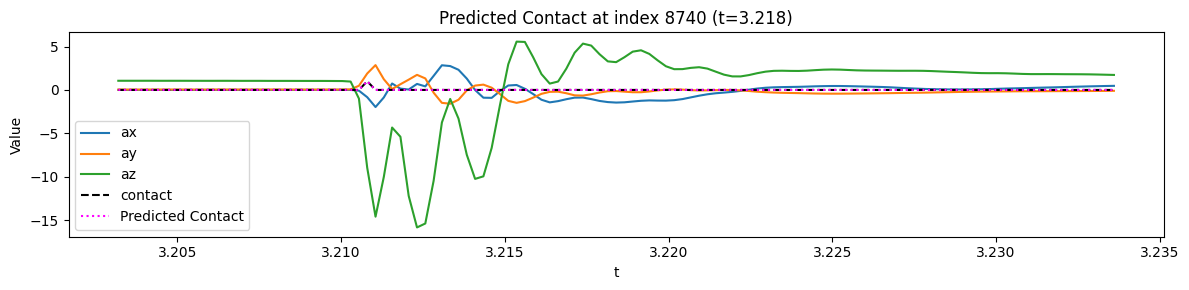

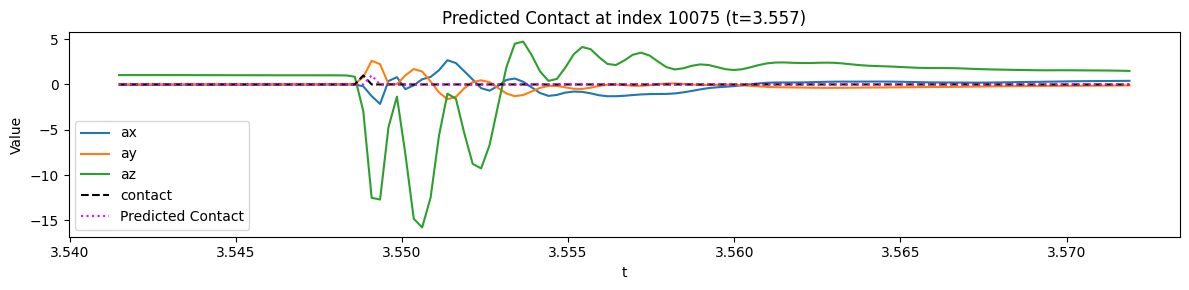

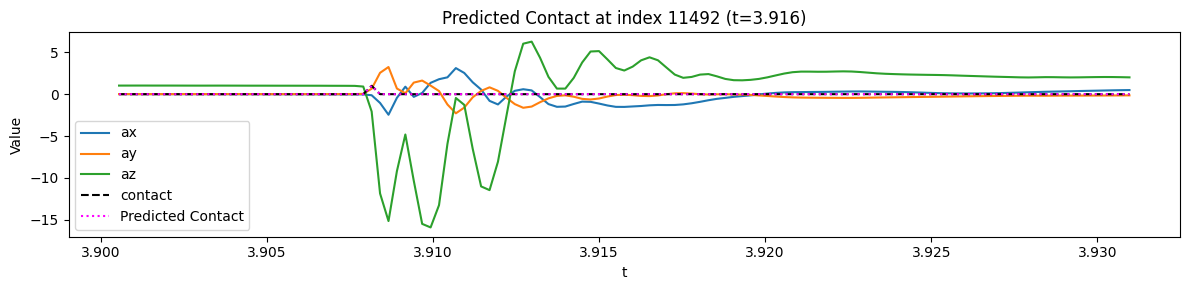

In [58]:
import matplotlib.pyplot as plt

# Plot ax, ay, az over time
plt.figure(figsize=(12, 2))
plt.plot(data['t'], data['ax'], label='ax')
plt.plot(data['t'], data['ay'], label='ay')
plt.plot(data['t'], data['az'], label='az')
plt.xlabel('t')
plt.ylabel('Acceleration')
plt.title('Acceleration over Time')
plt.tight_layout()
plt.show()

# Plot contact over time
plt.figure(figsize=(12, 2))
plt.plot(data['t'], data['contact'], label='contact')
plt.xlabel('t')
plt.ylabel('Contact')
plt.title('Contact over Time')
plt.tight_layout()
plt.show()

# Get NN predictions for all data points
model.eval()
with torch.no_grad():
    # Create sequences from all data
    X_all = scaler.transform(data[['ax', 'ay', 'az']].values)
    X_all_seq, _ = create_sequences(X_all, data['contact'].values, sequence_length)
    X_all_seq_tensor = torch.tensor(X_all_seq, dtype=torch.float32).to(device)
    assert X_all_seq_tensor.ndimension() == 3, "X_all_seq_tensor must be 3D"
    y_all_pred = model(X_all_seq_tensor).cpu().numpy().flatten()

# Use time_indices for correct alignment with y_all_pred
time_indices = data['t'][sequence_length:]

# Plot predictions.
plt.figure(figsize=(12, 2))
plt.plot(time_indices, y_all_pred)
prob_thresh = 0.01
plt.text(time_indices.iloc[-1], 0.95, f'Count > {prob_thresh}: {(y_all_pred > prob_thresh).sum()}', color='black', fontsize=12, ha='right', va='top')
plt.show()

# Indices where actual contact is 1
actual_contact_indices = data.index[data['contact'] == 1]
print("Actual contact indices:", actual_contact_indices.tolist())

# Indices where predicted contact probability is above 0.9
predicted_contact_indices = time_indices.index[y_all_pred > 0.9]
print("Predicted contact indices (prob > 0.9):", predicted_contact_indices.tolist())

window = sequence_length*2
for idx in predicted_contact_indices:
    start = max(idx - window, 0)
    end = min(idx + window, len(data) - 1)
    plt.figure(figsize=(12, 3))
    plt.plot(data['t'][start:end+1], data['ax'][start:end+1], label='ax')
    plt.plot(data['t'][start:end+1], data['ay'][start:end+1], label='ay')
    plt.plot(data['t'][start:end+1], data['az'][start:end+1], label='az')
    plt.plot(data['t'][start:end+1], data['contact'][start:end+1], label='contact', linestyle='--', color='black')
    plt.plot(data['t'][start:end+1], y_all_pred[start:end+1], color='magenta', linestyle=':', label='Predicted Contact')
    plt.xlabel('t')
    plt.ylabel('Value')
    plt.title(f'Predicted Contact at index {idx} (t={data["t"][idx]:.3f})')
    plt.legend()
    plt.tight_layout()
    plt.show()